# Bitcoin Predictive Model - fbprophet

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/05/tumblr_inline_omh3tnv5zk1r1x9ql_500.png)

Is a timeseries model produced by facebook.

## Imports & API

In [8]:
#Boolean value to determine if we want to use the api to update the stored bitcoin values
Update = True

### Imports

In [3]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#because of the built in plotting objects in Prophet, it is easier to import/use these externally from plt.
from matplotlib.pyplot import xlabel,ylabel,title

#scrap / API
import requests 

#Prophet
from fbprophet import Prophet

#Testing Stationarity
from statsmodels.tsa.stattools import adfuller

In [4]:
def test_stationarity(timeseries):
    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

In [7]:
key = 'Z1AZ31JOQWKFLEO4'

### BitCoin Market API Fetching & Cleaning

Variables of note: <br>
```c_code``` = Crypto value's code <br>
```c_market``` = Crypto value's market <br>
```c_``` = Cryto value's common name <br>
```crypto.columns = ['open','high','low','close','volume','cap']```

In [12]:
#declaring Fetch parameters
c_code = 'BTC'
c_market = 'USD'

if Update:
    #Fetching Data
    cryptos = requests.get(
        f"https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={c_code}&market={c_market}&apikey={key}")

    #Assigning "name" for ease
    c_ = cryptos.json()['Meta Data']['3. Digital Currency Name']

    #Organizing Data
    crypto = pd.DataFrame.from_dict(cryptos.json()['Time Series (Digital Currency Daily)'],orient='index',dtype='float')
    crypto = crypto.drop(['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
    crypto.columns = ['open','high','low','close','volume','cap']
    crypto.index = pd.to_datetime(crypto.index)

    #Cleaning Missing Data
    print("There are {} days between the first and last time stamp, the API captured {} days.".format(str(crypto.index[-1] - crypto.index[0]).split(" ")[0],len(crypto)))

    if int(str(crypto.index[-1] - crypto.index[0]).split(" ")[0]) - len(crypto) > 5:
        idx = pd.date_range(crypto.index[0], crypto.index[-1])
        crypto = crypto.reindex(idx, fill_value=np.nan)
        print("So we will need to interpolate the {} missing days.".format(crypto.isnull().sum()[0]))
        crypto = crypto.interpolate()
    else:
        print("as such we dont need to interpolate any missing days")

    crypto.to_csv('./Data/Market.csv')
    

else:
    #will import last fetched csv
    c_ = c_code
    crypto = pd.read_csv('./Data/Market.csv',index_col=0)
    crypto.index = pd.to_datetime(crypto.index)

There are -999 days between the first and last time stamp, the API captured 1000 days.
as such we dont need to interpolate any missing days


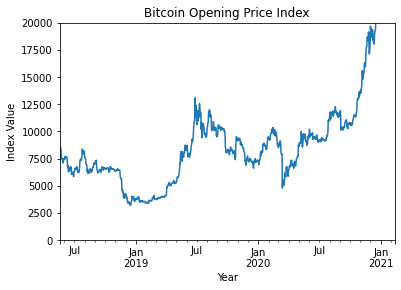

In [13]:
#Sanity Check
crypto.open.plot()
plt.title('{} Opening Price Index'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year');

## Seasonality & Trends

First off let us resample the entire Bitcoin opening value Dataset by: 

```
Daily means
Weekly means
Monthly means
Yearly means```

In [15]:
df_daily = crypto.resample('D').mean()

# Resampling to weekly frequency
df_week = crypto.resample('W').mean()

# Resampling to monthly frequency
df_month = crypto.resample('M').mean()

# Resampling to annual frequency
df_year = crypto.resample('A-DEC').mean()

In [8]:
# fig = plt.figure(figsize=[15, 10])
# plt.suptitle('{} exchanges, mean {}'.format(c_,c_market))

# plt.subplot(221)
# plt.plot(df_daily.open, '-', label='By Days')
# plt.legend()

# plt.subplot(222)
# plt.plot(df_week.open, '-', label='By Weeks')
# plt.legend()

# plt.subplot(223)
# plt.plot(df_month.open, '-', label='By Months')
# plt.legend()

# plt.subplot(224)
# plt.plot(df_year.open, '-', label='By Years')
# plt.legend()

# plt.show()

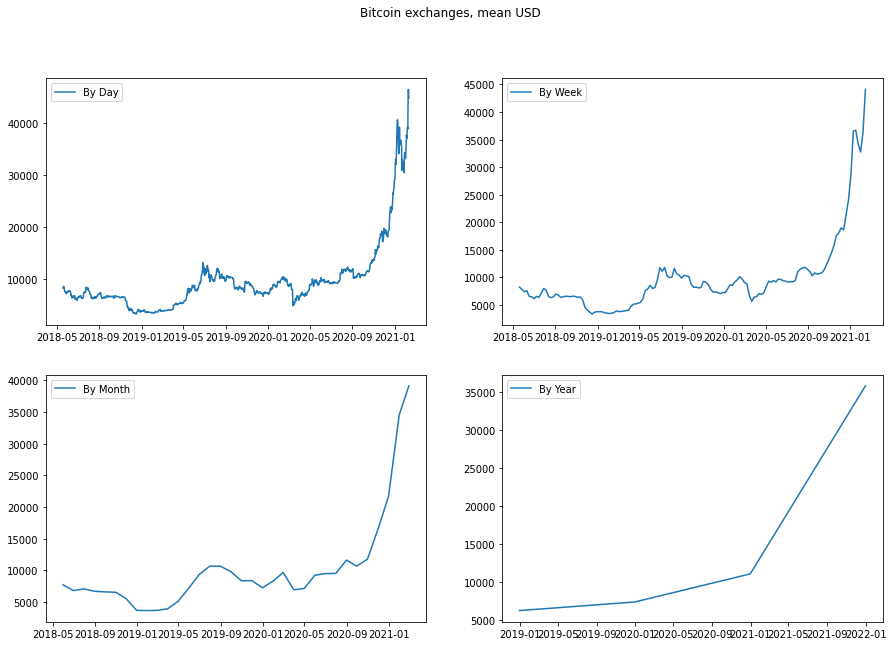

In [16]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('{} exchanges, mean {}'.format(c_,c_market))

for i,j in enumerate(['Day','Week','Month','Year']):
    temp = [df_daily,df_week,df_month,df_year]
    plt.subplot(221+i)
    plt.plot(temp[i].open,'-', label='By {}'.format(j))
    plt.legend()
plt.show()

## Stationary Testing

- In time series, a series is stationary if they do not have trend or seasonal effects.
- Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

Why do we want stationary data?
- By removing trends and seasonality, we are left with the residuals. This are the elements we want to model, the hard to interpret non-linear variations.

In [17]:
try:
    print("Dickey–Fuller test for Daily: p={}".format(round(adfuller(df_daily.open)[1],5)))
    print("Dickey–Fuller test for Weely: p={}".format(round(adfuller(df_week.open)[1],5)))
    print("Dickey–Fuller test for Monthly: p={}".format(round(adfuller(df_month.open)[1],5)))
    print("Dickey–Fuller test for Yearly: p={}".format(round(adfuller(df_year.open)[1],5)))
except:
    pass

Dickey–Fuller test for Daily: p=1.0
Dickey–Fuller test for Weely: p=0.99898
Dickey–Fuller test for Monthly: p=1.0
Dickey–Fuller test for Yearly: p=1.0


None of these intervals are stationary. That is not much of a surprise, clearly there is an underlying trend we may want to remove.

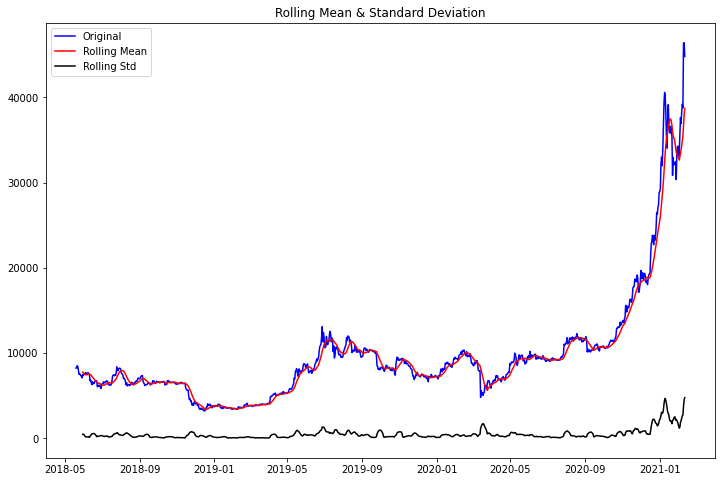

Results of Dickey-Fuller Test:
Test Statistic    5.152004
p-value           1.000000
dtype: float64
Daily Stationarity


In [18]:
test_stationarity(df_daily.open)
print("Daily Stationarity")

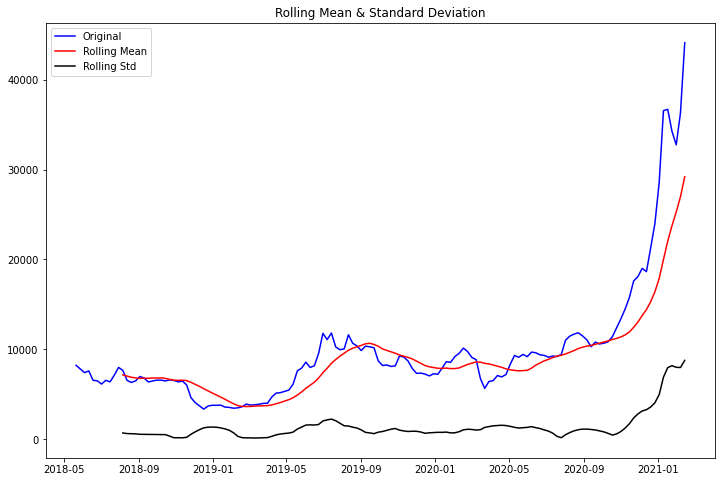

Results of Dickey-Fuller Test:
Test Statistic    2.334996
p-value           0.998976
dtype: float64
Weekly Stationarity


In [19]:
test_stationarity(df_week.open)
print("Weekly Stationarity")

## Bitcoin after Oct-25-2017, Seasonality & Trends

The lagging tail from 2014-2016 will likely be a problem.

As to avoid having more weight given to the time during which Bitcoin was worthless.
- ```more_rel``` will be a timeseries after Oct.25.2017, once Bitcoin has become 'more relivant'


- The reasoning being:

"Bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

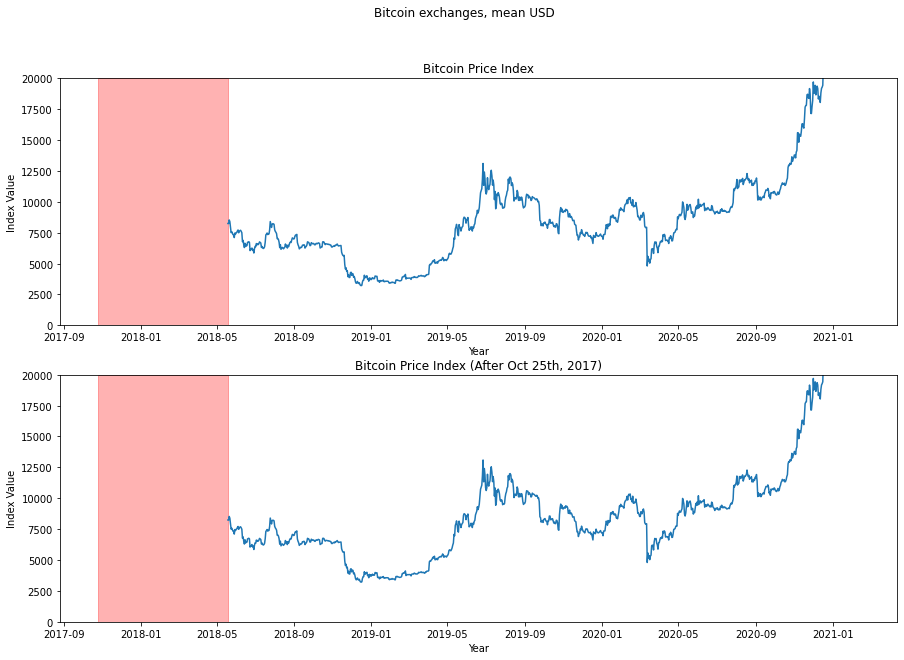

In [20]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('{} exchanges, mean {}'.format(c_,c_market))


plt.subplot(211)
plt.plot(crypto['open'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.3)

plt.title('{} Price Index'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year')

plt.subplot(212)
plt.plot(crypto[crypto.index>'2017-10-25']['open'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.3)

plt.title('{} Price Index (After Oct 25th, 2017)'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year');

plt.show()

In [21]:
more_rel = crypto[crypto.index>'2017-10-25']['open']

In [22]:
mr_daily = more_rel.resample('D').mean()

# Resampling to weekly frequency
mr_week = more_rel.resample('W').mean()

# Resampling to monthly frequency
mr_month = more_rel.resample('M').mean()

# Resampling to annual frequency
mr_year = more_rel.resample('A-DEC').mean()

# Resampling to quarterly frequency
mr_Q = more_rel.resample('Q-DEC').mean()

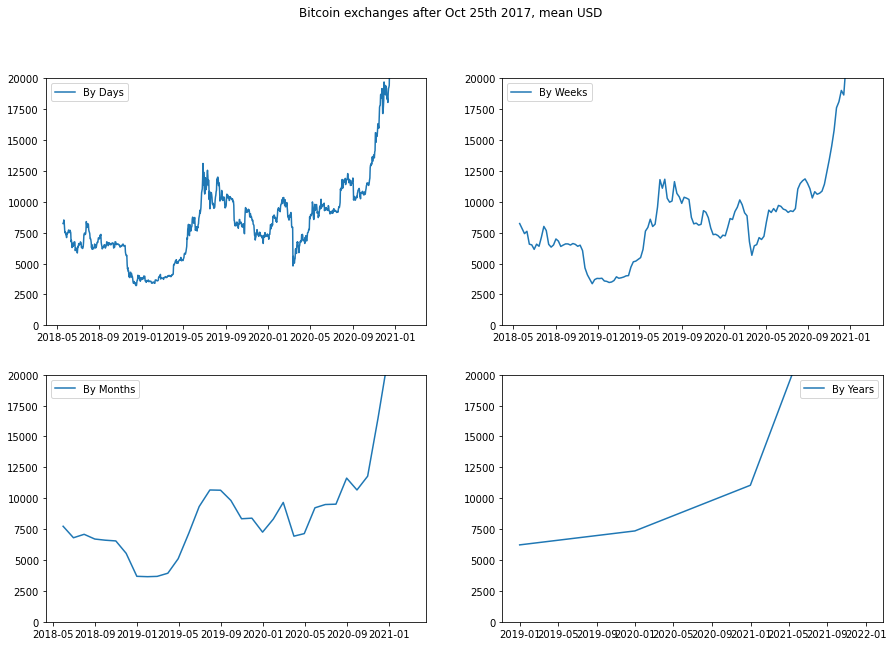

In [23]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('{} exchanges after Oct 25th 2017, mean {}'.format(c_,c_market))

plt.subplot(221)
plt.plot(mr_daily, '-', label='By Days')
plt.ylim(0,20000)
plt.legend()

plt.subplot(222)
plt.plot(mr_week, '-', label='By Weeks')
plt.ylim(0,20000)
plt.legend()

plt.subplot(223)
plt.plot(mr_month, '-', label='By Months')
plt.ylim(0,20000)
plt.legend()

plt.subplot(224)
plt.plot(mr_year, '-', label='By Years')
plt.ylim(0,20000)
plt.legend()

plt.show()

Again, we want to test if these ranges are stationary

In [24]:
try:
    print("Dickey–Fuller test for Daily: p={}".format(round(adfuller(mr_daily)[1],5)))
    print("Dickey–Fuller test for Weely: p={}".format(round(adfuller(mr_week)[1],5)))
    print("Dickey–Fuller test for Monthly: p={}".format(round(adfuller(mr_month)[1],5)))
    print("Dickey–Fuller test for Yearly: p={}".format(round(adfuller(mr_year)[1],5)))
except:
    pass

Dickey–Fuller test for Daily: p=1.0
Dickey–Fuller test for Weely: p=0.99898
Dickey–Fuller test for Monthly: p=1.0
Dickey–Fuller test for Yearly: p=1.0


Ang again none of these are stationary...

Daily Stationarity, after Oct 25th 2017


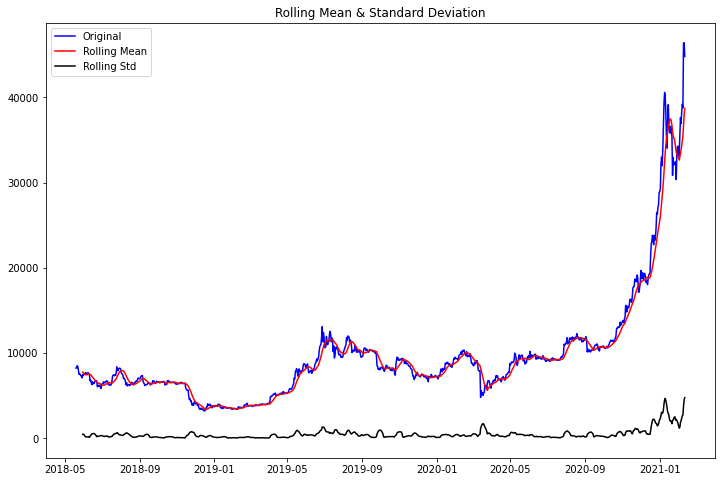

Results of Dickey-Fuller Test:
Test Statistic    5.152004
p-value           1.000000
dtype: float64


In [25]:
print("Daily Stationarity, after Oct 25th 2017")
test_stationarity(mr_daily)

Weekly Stationarity, after Oct 25th 2017


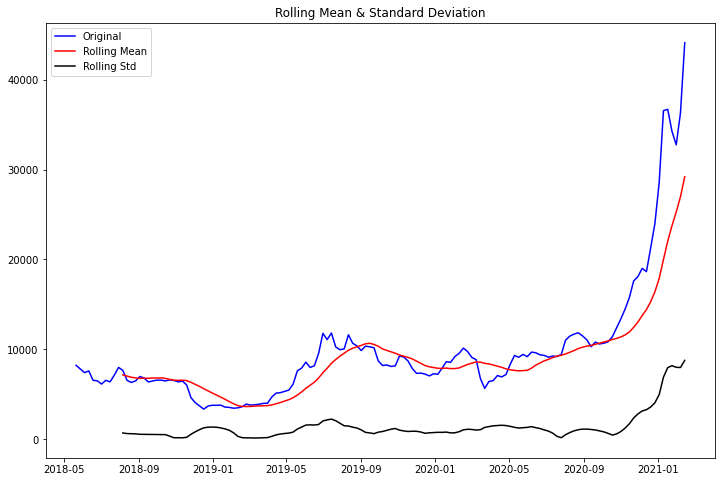

Results of Dickey-Fuller Test:
Test Statistic    2.334996
p-value           0.998976
dtype: float64


In [26]:
print("Weekly Stationarity, after Oct 25th 2017")
test_stationarity(mr_week)

Monthly Stationarity, after Oct 25th 2017


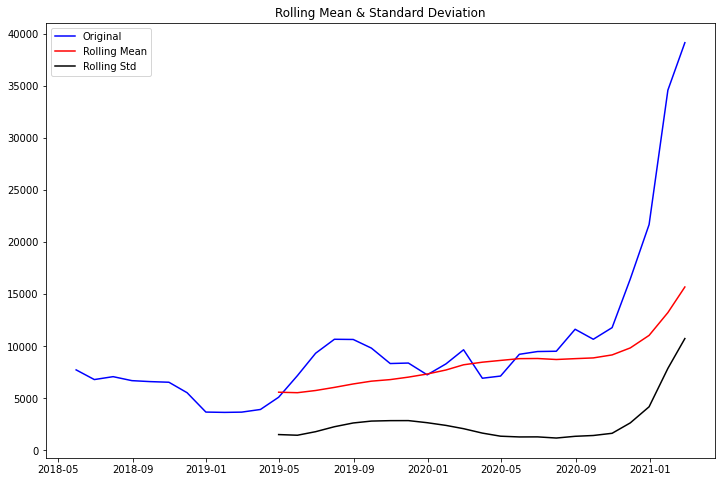

Results of Dickey-Fuller Test:
Test Statistic    4.059639
p-value           1.000000
dtype: float64


In [27]:
print("Monthly Stationarity, after Oct 25th 2017")
test_stationarity(mr_month)

## FbProphet - Complete

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/05/tumblr_inline_omh3tnv5zk1r1x9ql_500.png)

Is a timeseries model produced by facebook.

Key things:
The dataframes need to have only 2 columns ```['ds','y']``` and need to be a ``` timeseries object & float```


```'ds'``` = ```Date```

```'y'```   = ```Prediction``` 

In [28]:
df_daily.head()

,open,high,low,close,volume,cap
2018-05-19,8238.01,8390.80,8095.73,8233.49,17193.424276,17193.424276
2018-05-20,8233.49,8609.00,8163.90,8526.98,19957.057109,19957.057109
2018-05-21,8526.97,8595.31,8305.00,8381.24,21516.596486,21516.596486
2018-05-22,8386.89,8400.18,7935.11,7977.11,23710.902858,23710.902858
2018-05-23,7977.12,8031.90,7425.00,7501.95,42910.666774,42910.666774


In [29]:
model = Prophet(
    #daily_seasonality=True)
)

In [30]:
#not stationary, but the only one of that set that might be worth something
p_df_daily = df_daily.open.reset_index()
p_df_daily.columns = ['ds','y']

In [31]:
p_df_daily.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [32]:
p_df_daily.head()

,ds,y
0,2018-05-19,8238.01
1,2018-05-20,8233.49
2,2018-05-21,8526.97
3,2018-05-22,8386.89
4,2018-05-23,7977.12


In [33]:
model.fit(p_df_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = model.make_future_dataframe(periods=14, include_history=False)
future.head()

,ds
0,2021-02-12
1,2021-02-13
2,2021-02-14
3,2021-02-15
4,2021-02-16


In [35]:
predictions = model.predict(future)
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-12,37333.714086,38828.195618,41589.852348,37333.714086,37333.714086,2833.195193,2833.195193,2833.195193,-32.966892,-32.966892,-32.966892,2866.162085,2866.162085,2866.162085,0.0,0.0,0.0,40166.909279
1,2021-02-13,37484.653195,39105.713240,41994.482664,37484.653195,37484.653195,3067.442704,3067.442704,3067.442704,2.866521,2.866521,2.866521,3064.576183,3064.576183,3064.576183,0.0,0.0,0.0,40552.095899
2,2021-02-14,37635.592304,39555.539620,42304.483272,37635.592304,37635.592304,3264.267146,3264.267146,3264.267146,13.594183,13.594183,13.594183,3250.672962,3250.672962,3250.672962,0.0,0.0,0.0,40899.859450
3,2021-02-15,37786.531414,39793.395276,42548.376401,37786.531414,37786.531414,3375.714581,3375.714581,3375.714581,-46.372755,-46.372755,-46.372755,3422.087336,3422.087336,3422.087336,0.0,0.0,0.0,41162.245995
4,2021-02-16,37937.470523,40170.972501,42988.320607,37937.470523,37937.470523,3596.667794,3596.667794,3596.667794,19.919235,19.919235,19.919235,3576.748559,3576.748559,3576.748559,0.0,0.0,0.0,41534.138317


In [36]:
simple_predictions = predictions[['ds','yhat']]
simple_predictions.head()

,ds,yhat
0,2021-02-12,40166.909279
1,2021-02-13,40552.095899
2,2021-02-14,40899.859450
3,2021-02-15,41162.245995
4,2021-02-16,41534.138317


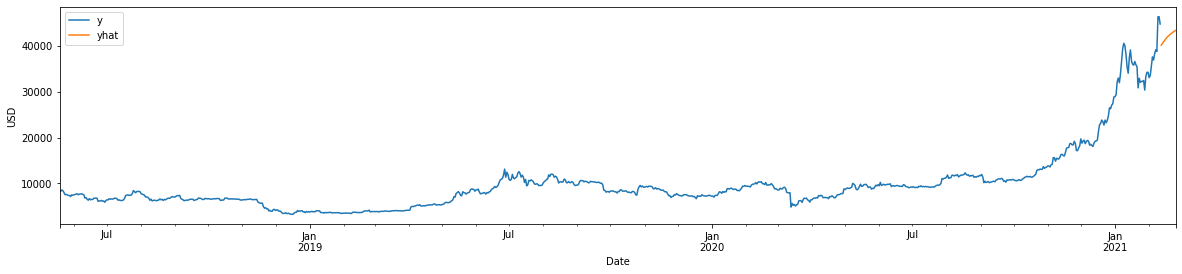

In [37]:
# We copy the data to avoid modifying the original.
formated_predictions = simple_predictions.copy()

# For this plot, it'd be convenient to have a datetime index
formated_predictions['ds'] = pd.to_datetime(formated_predictions['ds'])

# Plot of the original data
ax = p_df_daily.set_index('ds').plot(figsize=(20,4))

# Plot of the forecasted values
formated_predictions.set_index('ds').plot(figsize=(20,4), ax=ax)
xlabel('Date')
ylabel('USD');

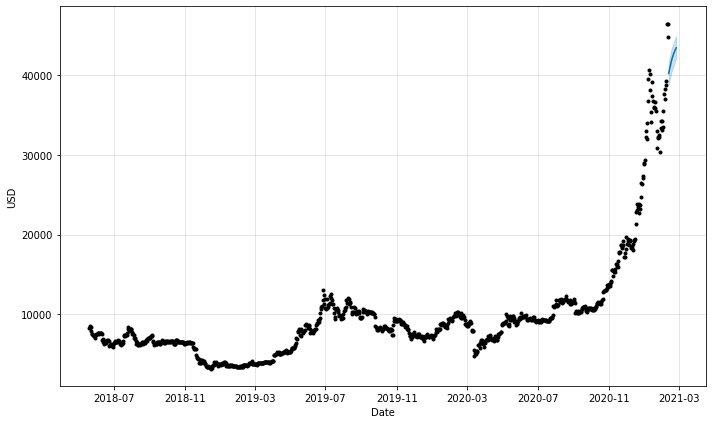

In [38]:
model.plot(predictions)
xlabel('Date')
ylabel('USD');

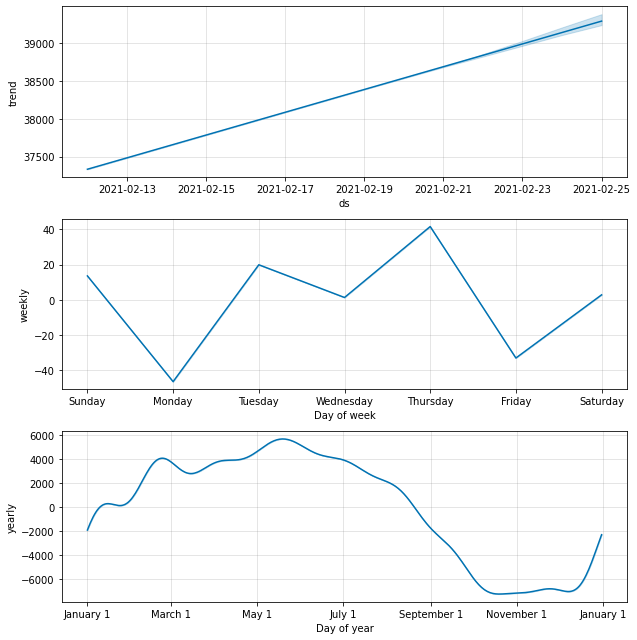

In [39]:
model.plot_components(predictions);

## FbProphet - Post Oct-25-2017

In [40]:
model = Prophet(#daily_seasonality=True)
)

In [41]:
p_mr_daily = mr_daily.reset_index()
p_mr_daily.columns = ['ds','y']

In [42]:
p_mr_daily.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [43]:
model.fit(p_mr_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
future = model.make_future_dataframe(periods=14, include_history=False)
future.head()

,ds
0,2021-02-12
1,2021-02-13
2,2021-02-14
3,2021-02-15
4,2021-02-16


In [45]:
predictions = model.predict(future)
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-12,37333.714086,38804.192183,41563.207280,37333.714086,37333.714086,2833.195193,2833.195193,2833.195193,-32.966892,-32.966892,-32.966892,2866.162085,2866.162085,2866.162085,0.0,0.0,0.0,40166.909279
1,2021-02-13,37484.653195,39145.998843,41900.280914,37484.653195,37484.653195,3067.442704,3067.442704,3067.442704,2.866521,2.866521,2.866521,3064.576183,3064.576183,3064.576183,0.0,0.0,0.0,40552.095899
2,2021-02-14,37635.592304,39593.223285,42286.412589,37635.592304,37635.592304,3264.267146,3264.267146,3264.267146,13.594183,13.594183,13.594183,3250.672962,3250.672962,3250.672962,0.0,0.0,0.0,40899.859450
3,2021-02-15,37786.531414,39710.367043,42471.099917,37786.531414,37786.531414,3375.714581,3375.714581,3375.714581,-46.372755,-46.372755,-46.372755,3422.087336,3422.087336,3422.087336,0.0,0.0,0.0,41162.245995
4,2021-02-16,37937.470523,40147.138497,42904.727932,37937.470523,37937.470523,3596.667794,3596.667794,3596.667794,19.919235,19.919235,19.919235,3576.748559,3576.748559,3576.748559,0.0,0.0,0.0,41534.138317


In [46]:
simple_predictions = predictions[['ds','yhat']]
simple_predictions.head()

,ds,yhat
0,2021-02-12,40166.909279
1,2021-02-13,40552.095899
2,2021-02-14,40899.859450
3,2021-02-15,41162.245995
4,2021-02-16,41534.138317


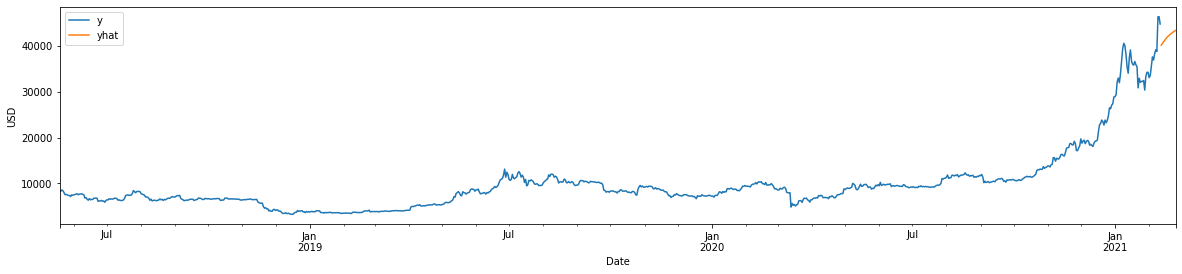

In [47]:
# We copy the data to avoid modifying the original.
formated_predictions = simple_predictions.copy()

# For this plot, it'd be convenient to have a datetime index
formated_predictions['ds'] = pd.to_datetime(formated_predictions['ds'])

# Plot of the original data
ax = p_mr_daily.set_index('ds').plot(figsize=(20,4))

# Plot of the forecasted values
formated_predictions.set_index('ds').plot(figsize=(20,4), ax=ax)
xlabel('Date')
ylabel('USD');

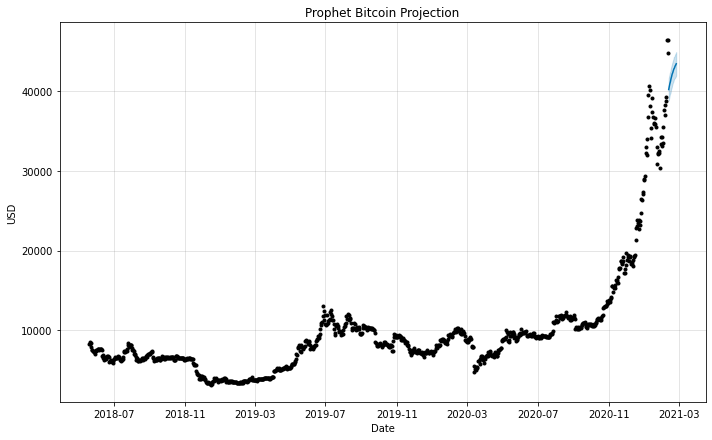

In [48]:
model.plot(predictions)
xlabel('Date')
ylabel('USD')
title('Prophet Bitcoin Projection');

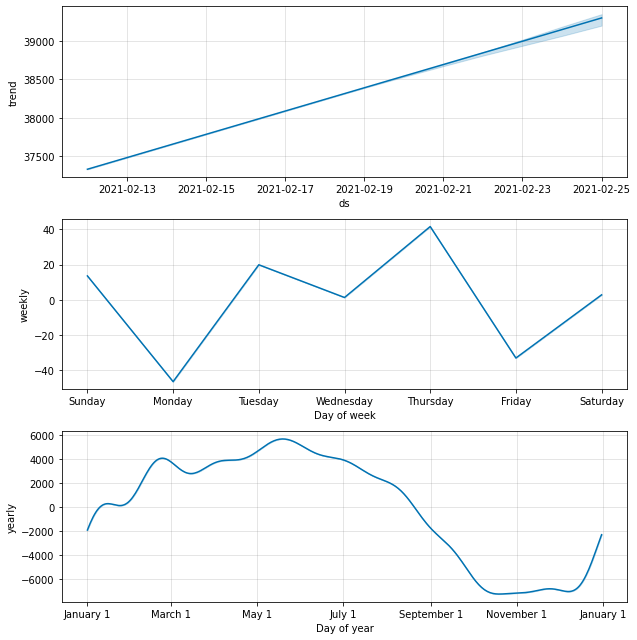

In [49]:
model.plot_components(predictions);